Here, we are benchmarking how Bayesian optimization algorithms from the [Optuna](https://optuna.readthedocs.io/en/stable/index.html) package perform at optimizing a publicly available dataset related to a Suzuki-Miyaura coupling. The dataset for this can be found [here](https://github.com/doyle-lab-ucla/edboplus/tree/main/examples/publication/Suzuki/data) and was first described in this publication:
- [Doyle et al. A Multi-Objective Active Learning Platform and Web App for Reaction Optimization. **2022** ChemRxiv](https://chemrxiv.org/engage/chemrxiv/article-details/62f6966269f3a5df46b5584b)

This real-world benchmark problem has three categorical input variables: Ligand, base, and solvent, and the goal is to maximize the two target varbiables conversion and selectivity.

Specifically, we are going to compare three approaches here: Random sampling (baseline), Optuna's *TPESampler* (Tree-structured Parzen estimator), and Optuna's *TPESampler* with a provided categorical distance function. For categorical features, it may be quite favorable to provide features that describe the similarity of input categories. The *categorical_distance_func* of Optuna's *TPESampler* is intended to do just that, however currently it is poorly documented how to use this argument and what improvements can be expected from this. So, we are going to look at this here. Originally, I also looked at the *BoTorchSampler*. However, this is extremly slow and in my experience provided no added benefits, so this is commented out here.

In [1]:
import pandas as pd
import numpy as np
import random
from itertools import product
import matplotlib.pyplot as plt
import optuna
from optuna.distributions import CategoricalDistribution
import warnings
from pygmo import hypervolume
from copy import deepcopy
from functools import partial
# from optuna_integration import BoTorchSampler
# from optuna_integration.botorch import qparego_candidates_func
warnings.filterwarnings("ignore", ".*is an experimental feature")
# warnings.filterwarnings("ignore", ".*option is an experimental feature")
# warnings.filterwarnings("ignore", ".*qparego_candidates_func")
# warnings.filterwarnings("ignore", ".*qExpectedImprovement")
# warnings.filterwarnings("ignore", ".*BoTorchSampler is experimental")
optuna.logging.set_verbosity(optuna.logging.WARNING)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["xtick.labelsize"] = 6
plt.rcParams["ytick.labelsize"] = 6
plt.rcParams["legend.fontsize"] = 6

df_orig = pd.read_csv("https://raw.githubusercontent.com/doyle-lab-ucla/edboplus/main/examples/publication/Suzuki/data/dataset_B2_DFT_clean.csv")

n_repeats = 1000
n_experiments = 40
optimize_dirs = ["maximize", "maximize"]
ref_point = [100.001, 100.001]
names_X = ["ligand", "base", "solvent"]
names_y = ["objective_conversion", "objective_selectivity"]

df = df_orig[names_X + names_y] # just for having a better overview of core features
df.loc[:, "base"] = df.loc[:, "base"].astype("str")
ligands = df["ligand"].unique().tolist()
bases = df["base"].unique().tolist()
solvents = df["solvent"].unique().tolist()


def get_pareto(inputs, results, names_X, names_y, optimize_dirs):
    # http://stackoverflow.com/a/40239615
    # Adapted to handle replicates and "different input parameters-same outcome" cases
    df = pd.DataFrame(np.hstack([inputs, results]), columns=names_X+names_y)
    df = df.astype({k: float for k in names_y})
    
    df = df.groupby(names_X, as_index=False).mean(numeric_only=True)
    df_y = df[names_y].astype(np.float32)
    replicates = df_y.reset_index().groupby(names_y)["index"].agg(
        list).reset_index()["index"].values.tolist()
    replicates = [y for y in replicates if len(replicates) > 1]
    change_sign = np.repeat(
        np.array([[1 if x == "minimize" else -1 for x in optimize_dirs]]),
        len(df_y), axis=0)
    y = df_y.values * change_sign
    
    is_pareto = np.ones(y.shape[0], dtype=bool)
    for idx0, row in enumerate(y):
        to_remove = [x for x in replicates if idx0 in x]
        if len(to_remove) > 0:
            to_remove = to_remove[0]
        idx1 = [x for x in list(range(idx0)) if x not in to_remove]
        idx2 = [x for x in list(range(idx0+1, len(df))) if x not in to_remove]
        
        if idx0 == 0:
            cond0 = np.all(np.any(y[:0] > row, axis=1))
            cond1 = np.all(np.any(y[idx2] > row, axis=1))
        else:
            cond0 = np.all(np.any(y[idx1] > row, axis=1))
            cond1 = np.all(np.any(y[idx2] > row, axis=1))
            
        is_pareto[idx0] = cond0 & cond1
    return df[is_pareto]

First, we establish our random sampling baseline:

In [2]:
# You can also use optuna's RandomSampler for this, but there is some logic
# that goes beyond the scope of this notebook why I am not doing this here.

inputs_rnd = np.zeros((n_repeats, n_experiments, 3), dtype="U32")
results_rnd = np.zeros((n_repeats, n_experiments, 3))
combos_all = list(product(ligands, bases, solvents))

for idx0 in range(n_repeats):
    inputs_rnd[idx0] = np.array(random.sample(combos_all, k=n_experiments))
    idx_lookup = np.stack(np.where(
        (inputs_rnd[idx0][:, None] == df[names_X].values).all(axis=-1)), 
                          axis=-1)
    results_rnd[idx0, :, 0:2] = df.loc[idx_lookup[:, 1], names_y]
    
    for idx1 in range(1, n_experiments):
        pareto_front = get_pareto(
            inputs_rnd[idx0, :idx1], results_rnd[idx0, :idx1, 0:2],
            names_X, names_y, optimize_dirs)
        if pareto_front.shape[0] == 0:
            results_rnd[idx0, idx1, 2] = 0
        else:
            hv = hypervolume(100 - pareto_front[names_y])
            results_rnd[idx0, idx1, 2] = hv.compute(ref_point) / 100
        
results_rnd_steps = np.maximum.accumulate(results_rnd, axis=1)

Preparing the *categorical_distance_func* argument input:

In [3]:
props_ligands = [
    "ligand"] + [x for x in df_orig.columns.tolist() if "ligand_" in x]
props_solvents = [
    "solvent"] + [x for x in df_orig.columns.tolist() if "solvent_" in x]
# file does not have properties for bases...

def get_distance_func(df, cols):
    df_props = df_orig.loc[:, cols].groupby(cols[0]).mean(numeric_only=True)
    df_props = df_props.apply(
        lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=0)
    m_dist = np.zeros((len(df_props), len(df_props)))
    
    for idx0 in range(m_dist.shape[0]):
        for idx1 in range(idx0, m_dist.shape[0]):
            m_dist[idx0, idx1] = np.linalg.norm(
                df_props.iloc[idx0, :].values - df_props.iloc[idx1, :].values)
    
    m_dist = np.abs(m_dist + m_dist.T - np.diag(np.diag(m_dist)))
    m_dist = m_dist / np.max(m_dist)    
    names = df_props.index.tolist()
    m_dist = pd.DataFrame(m_dist, columns=names, index=names)
    
    def _get_distance_func(par0, par1, df):
        return df.loc[par0, par1]
    
    dist_func = partial(_get_distance_func, df=m_dist) 
    return dist_func, m_dist


dist_func_ligands, m_dist_ligands = get_distance_func(df_orig, props_ligands)
dist_func_solvents, m_dist_solvents = get_distance_func(
    df_orig, props_solvents)

print("Testing:")
print("MeOH vs MeCN:", dist_func_solvents("MeOH", "MeCN"))
print("MeCN vs MeOH:", dist_func_solvents("MeCN", "MeOH"))
print("MeOH vs MeOH:", dist_func_solvents("MeOH", "MeOH"))

categorical_distance_func = {
    "ligand": dist_func_ligands,
    "solvent": dist_func_solvents
    }

Testing:
MeOH vs MeCN: 0.911960505224688
MeCN vs MeOH: 0.911960505224688
MeOH vs MeOH: 0.0


In [4]:
def run_optuna_study_for_suzuki_problem(sampler, n_repeats, n_experiments):
    inputs = np.zeros((n_repeats, n_experiments, 3), dtype="U32")
    results = np.zeros((n_repeats, n_experiments, 3))

    for idx0 in range(n_repeats):
        _sampler = deepcopy(sampler)
        study = optuna.create_study(sampler=_sampler, directions=optimize_dirs)
        for idx1 in range(0, n_experiments):
            trials = study.ask()
            ligand = trials.suggest_categorical("ligand", choices=ligands)
            base = trials.suggest_categorical("base", choices=bases)
            solvent = trials.suggest_categorical("solvent", choices=solvents)

            inputs[idx0, idx1, :] = [ligand, base, solvent]
            results[idx0, idx1, 0:2] = df[
                (df["ligand"] == ligand) & (df["base"] == base) & 
                (df["solvent"] == solvent)][names_y].values[0]
            
            study.tell(trials, results[idx0, idx1, 0:2].tolist())
            
            pareto_front = get_pareto(
                inputs[idx0, :idx1], 
                results[idx0, :idx1, 0:2],
                names_X, names_y, optimize_dirs)
            if pareto_front.shape[0] == 0:
                results[idx0, idx1, 2] = 0
            else:
                hv = hypervolume(100 - pareto_front[names_y])
                results[idx0, idx1, 2] = hv.compute(ref_point) / 100
                
    return np.maximum.accumulate(results, axis=1), results, pareto_front


distributions = {
    "ligand": CategoricalDistribution(choices=ligands),
    "base": CategoricalDistribution(choices=bases),
    "solvent": CategoricalDistribution(choices=solvents),
    }

sampler0 = optuna.samplers.TPESampler(multivariate=True)
sampler1 = optuna.samplers.TPESampler(
    multivariate=True, categorical_distance_func=categorical_distance_func)
# sampler2 = BoTorchSampler(candidates_func=qparego_candidates_func)

results_bo_case0_steps, results_bo_case0, pareto_front_bo_case0 = (
    run_optuna_study_for_suzuki_problem(sampler0, n_repeats, n_experiments))
results_bo_case1_steps, results_bo_case1, pareto_front_bo_case1 = (
    run_optuna_study_for_suzuki_problem(sampler1, n_repeats, n_experiments))

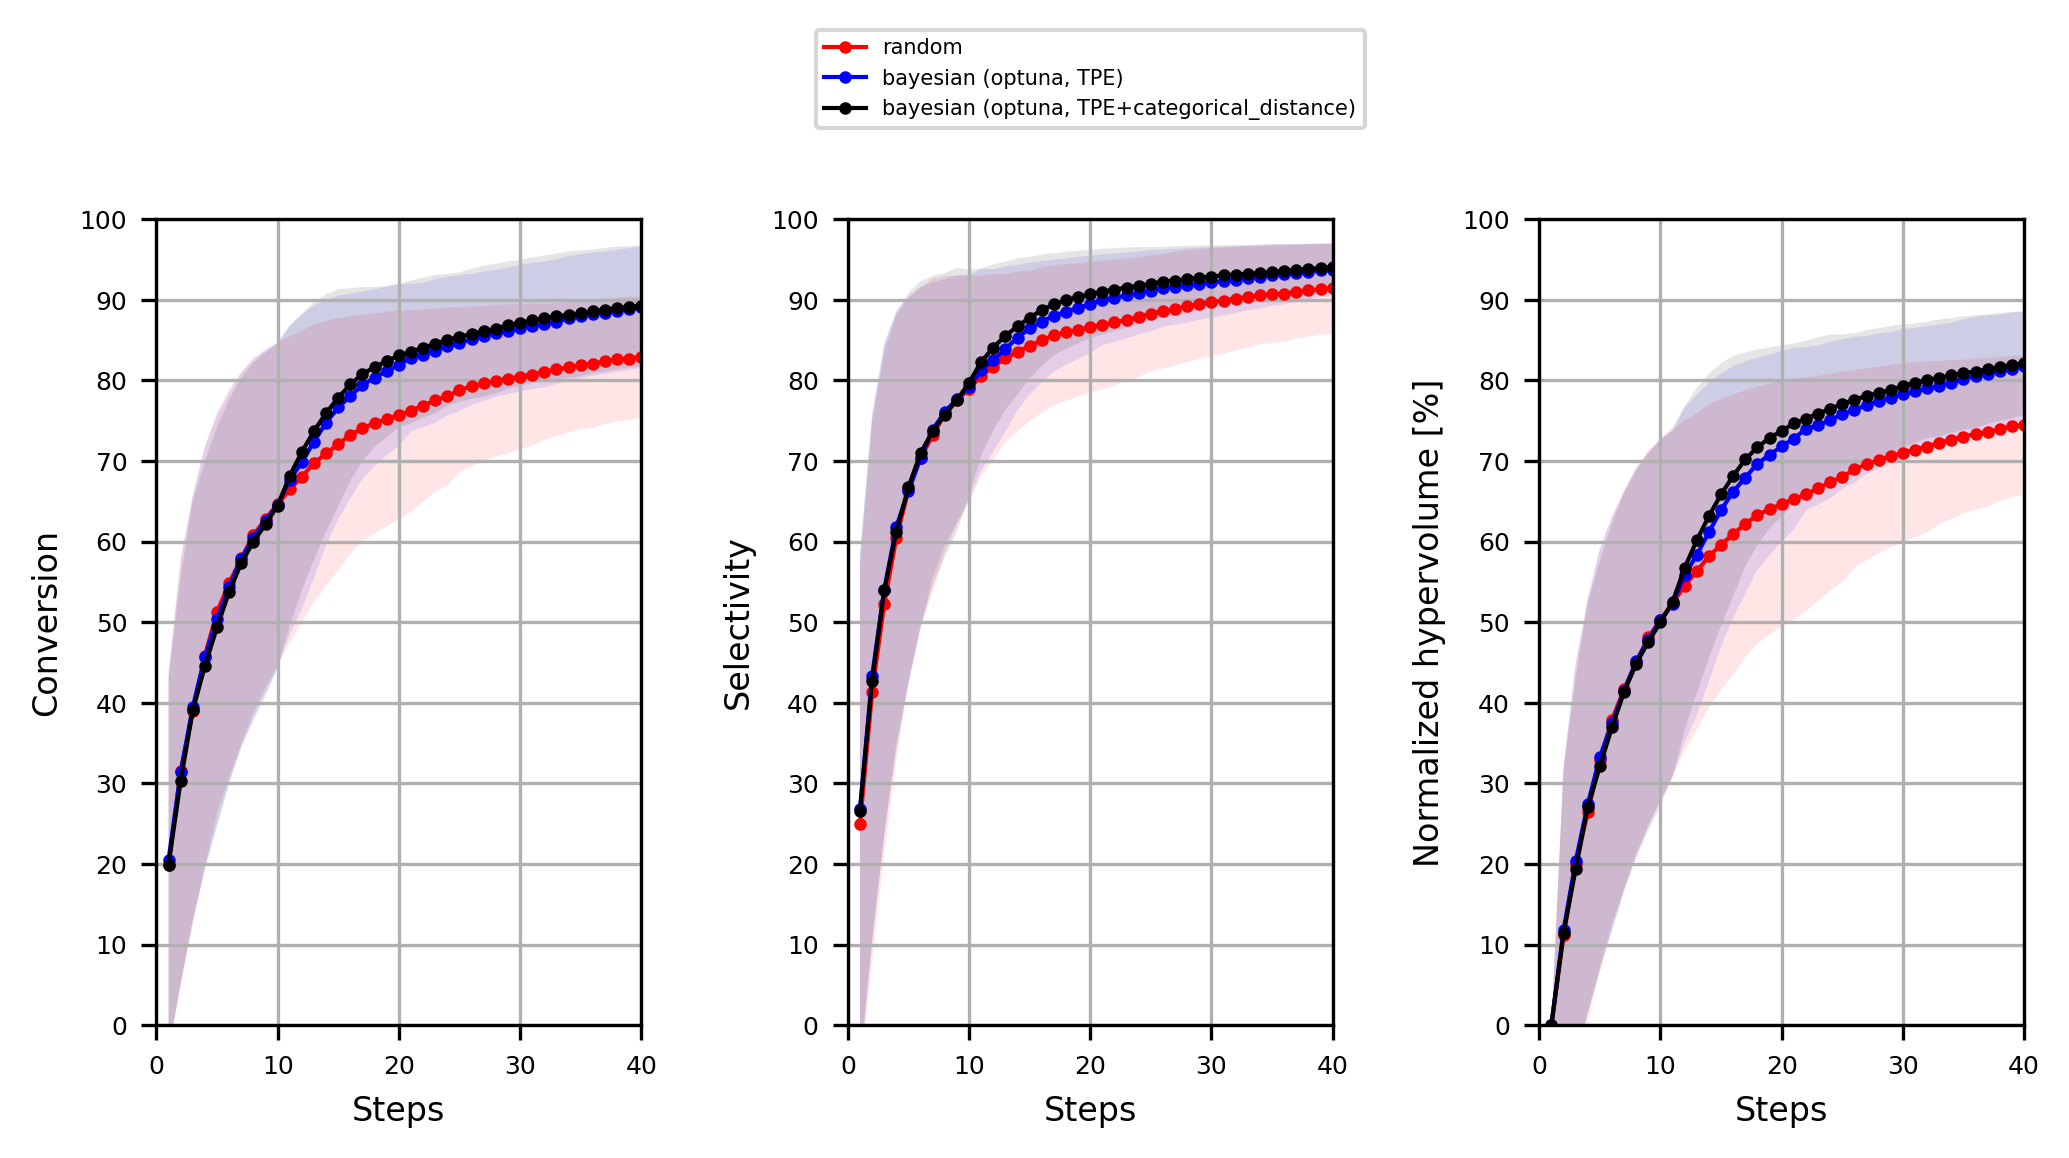

In [5]:
means_rnd = [
    np.mean(x, axis=0) for x in np.rollaxis(results_rnd_steps, 2)]
stds_rnd = [np.std(x, axis=0) for x in np.rollaxis(results_rnd_steps, 2)]

means_bo_case0 = [
    np.mean(x, axis=0) for x in np.rollaxis(results_bo_case0_steps, 2)]
stds_bo_case0 = [
    np.std(x, axis=0) for x in np.rollaxis(results_bo_case0_steps, 2)]

means_bo_case1 = [
    np.mean(x, axis=0) for x in np.rollaxis(results_bo_case1_steps, 2)]
stds_bo_case1 = [
    np.std(x, axis=0) for x in np.rollaxis(results_bo_case1_steps, 2)]

tmp = [[means_rnd, stds_rnd],
       [means_bo_case0, stds_bo_case0],
       [means_bo_case1, stds_bo_case1],
       ]
labels = ["random", 
          "bayesian (optuna, TPE)", 
          "bayesian (optuna, TPE+categorical_distance)", 
          ]
colors = ["red", "blue", "black"]

fig, ax = plt.subplots(1, 3, figsize=(7, 4))
for idx0, (means, stds) in enumerate(tmp):
    for idx1, (mean, std) in enumerate(zip(means, stds)):
        ax[idx1].plot(
            range(1, n_experiments+1), mean, color=colors[idx0], linewidth=1, 
            marker=".", markersize=4, label=labels[idx0])
        ax[idx1].fill_between(
            range(1, n_experiments+1), mean + std, mean - std, 
            facecolor=colors[idx0], alpha=0.1)

y_lims = [(0, 100), (0, 100), (0, 100)]
y_labels = ["Conversion", "Selectivity", "Normalized hypervolume [%]"]
for idx2 in range(3):
    ax[idx2].set_ylim(y_lims[idx2])
    ax[idx2].yaxis.set_ticks(np.arange(0, 101, 10))
    ax[idx2].set_xlim([0, n_experiments])
    ax[idx2].set_xlabel("Steps", fontsize=8)
    ax[idx2].set_ylabel(y_labels[idx2], fontsize=8)
    ax[idx2].grid()

ax[1].legend(loc="lower center", bbox_to_anchor=(0, 1.1, 1, 0.2), ncol=1, fontsize=5)
plt.tight_layout()
plt.show()

Conclusion: The *TPESampler* adds quite a nice improvement over the random sampling baseline. The *categorical_distance_func* seems only a marginal effect here.

Lastly and just for fun, plotting the results from the last repeat for all three methods compared in this notebook

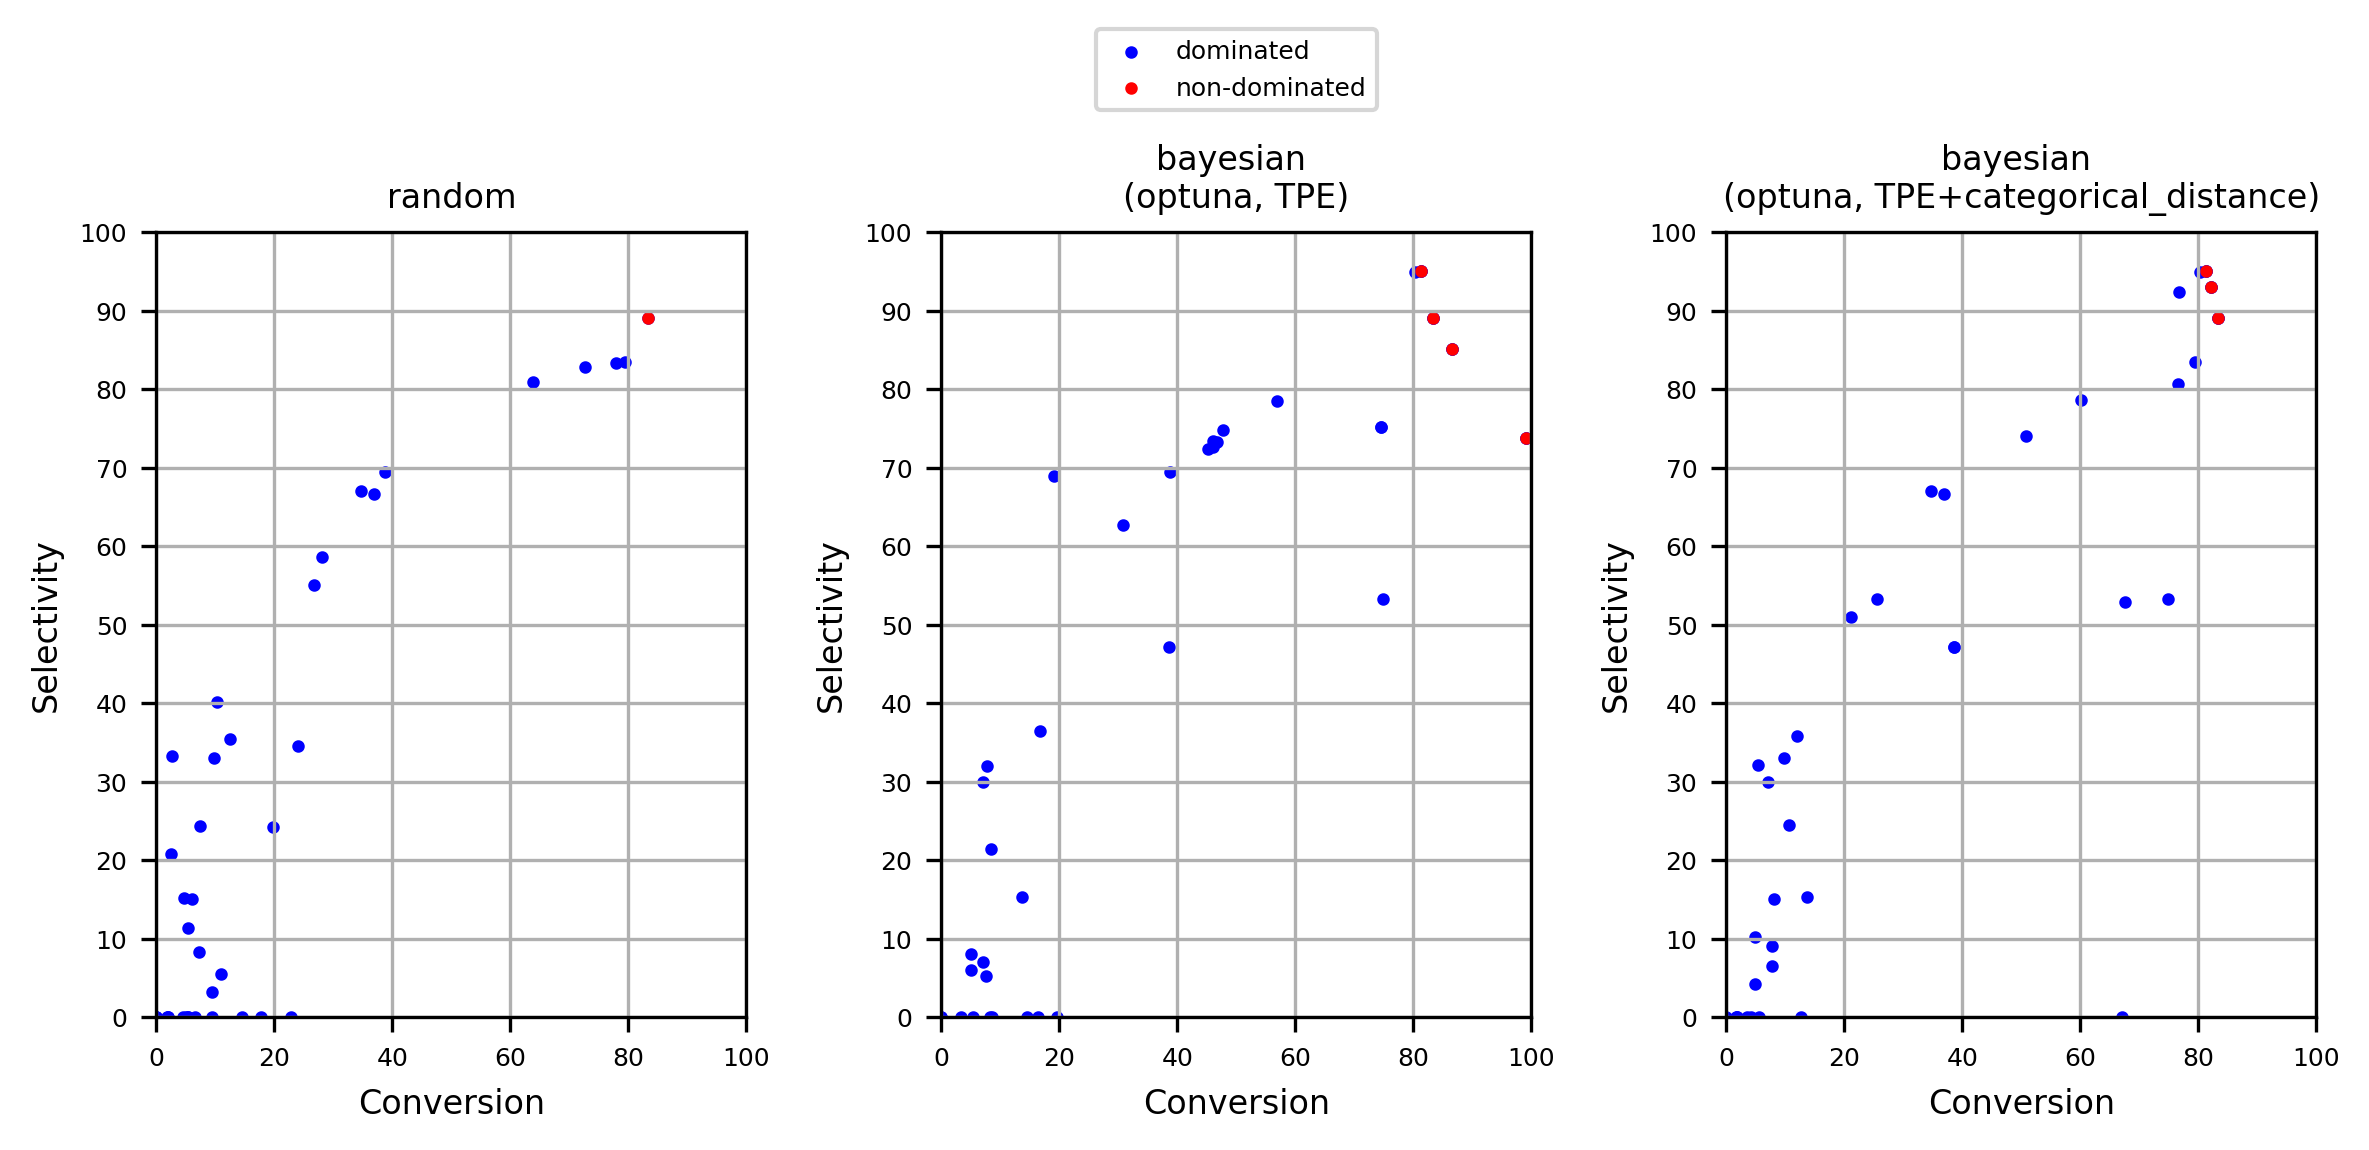

In [6]:
fig, ax = plt.subplots(1, 3, figsize=(8, 4))
ax[0].scatter(results_rnd[-1, :, 0], results_rnd[-1, :, 1], 
              s=4, color="blue", label="dominated")
ax[0].scatter(pareto_front.loc[:, "objective_conversion"].values, 
              pareto_front.loc[:, "objective_selectivity"].values, 
              s=4, color="red", label="non-dominated")
ax[0].set_title("random", fontsize=8)

ax[1].scatter(results_bo_case0[-1, :, 0], results_bo_case0[-1, :, 1], 
              s=4, color="blue", label="dominated")
ax[1].scatter(pareto_front_bo_case0.loc[:, "objective_conversion"].values, 
              pareto_front_bo_case0.loc[:, "objective_selectivity"].values, 
              s=4, color="red", label="non-dominated")
ax[1].set_title("bayesian \n(optuna, TPE)", fontsize=8)

ax[2].scatter(results_bo_case1[-1, :, 0], results_bo_case1[-1, :, 1], 
              s=4, color="blue", label="dominated")
ax[2].scatter(pareto_front_bo_case1.loc[:, "objective_conversion"].values, 
              pareto_front_bo_case1.loc[:, "objective_selectivity"].values, 
              s=4, color="red", label="non-dominated")
ax[2].set_title("bayesian \n(optuna, TPE+categorical_distance)", fontsize=8)

for idx2 in range(3):
    ax[idx2].set_ylim(y_lims[idx2])
    ax[idx2].yaxis.set_ticks(np.arange(0, 101, 10))
    ax[idx2].set_xlim(y_lims[idx2])
    ax[idx2].set_xlabel("Conversion", fontsize=8)
    ax[idx2].set_ylabel("Selectivity", fontsize=8)
    ax[idx2].grid()
ax[1].legend(loc="lower center", bbox_to_anchor=(0, 1.14, 1, 0.2), ncol=1)
plt.tight_layout()
plt.show()